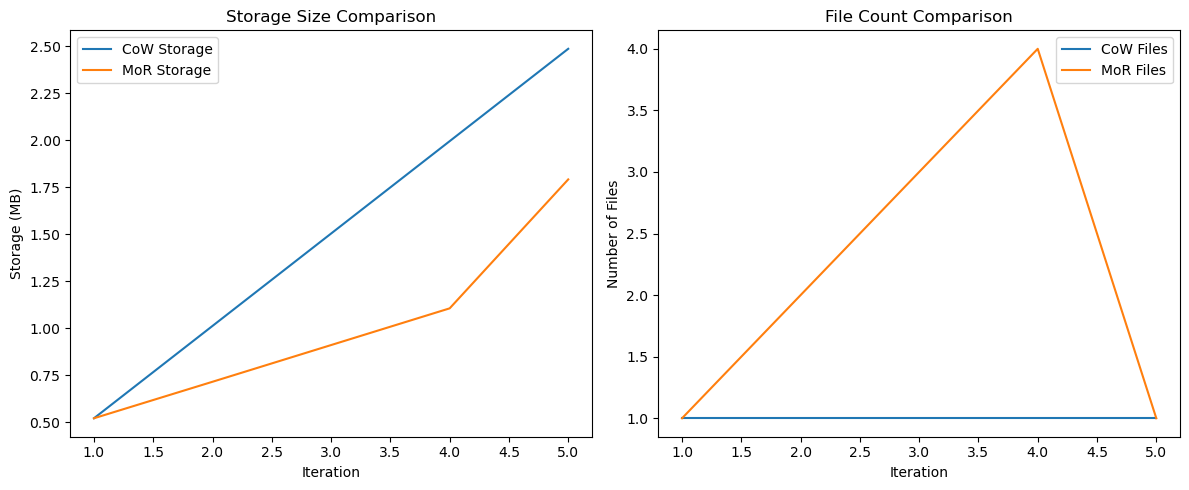


📊 Detailed Storage and File Analysis:
 iteration  cow_storage_mb  mor_storage_mb  cow_file_count  mor_file_count
         1        0.521763        0.521767               1               1
         2        1.012898        0.715861               1               2
         3        1.504052        0.911018               1               3
         4        1.995209        1.106174               1               4
         5        2.486359        1.791842               1               1


In [1]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *
import os
import shutil
import pandas as pd

# Initialize Spark Session
spark = SparkSession.builder \
    .appName("SimpleHudiCreate") \
    .config("spark.serializer", "org.apache.spark.serializer.KryoSerializer") \
    .config("spark.sql.extensions", "org.apache.spark.sql.hudi.HoodieSparkSessionExtension") \
    .config("spark.sql.catalog.spark_catalog", "org.apache.spark.sql.hudi.catalog.HoodieCatalog") \
    .getOrCreate()

# Advanced Storage Analysis Function
def detailed_storage_analysis(base_path, num_iterations=5):
    # Prepare results storage
    results = {
        'iteration': [],
        'cow_storage_mb': [],
        'mor_storage_mb': [],
        'cow_file_count': [],
        'mor_file_count': []
    }

    # Generate larger dataset for meaningful comparison
    def generate_customer_data(iteration):
        return spark.createDataFrame([
            (i, f"Customer_{i}", 
             f"City_{iteration}", 
             1000 * iteration, 
             f"2023-{iteration:02d}-01") 
            for i in range(1, 1000)
        ], ["customer_id", "name", "city", "spend", "date"])

    # Paths for storage analysis
    cow_path = f"{base_path}/cow_storage"
    mor_path = f"{base_path}/mor_storage"

    # Clean previous runs
    for path in [cow_path, mor_path]:
        shutil.rmtree(path, ignore_errors=True)

    # Function to get directory size
    def get_directory_size(directory):
        total_size = 0
        for dirpath, dirnames, filenames in os.walk(directory):
            for f in filenames:
                fp = os.path.join(dirpath, f)
                total_size += os.path.getsize(fp)
        return total_size / (1024 * 1024)  # Convert to MB

    # Table Configurations
    cow_options = {
        'hoodie.table.name': 'customers_cow',
        'hoodie.datasource.write.table.type': 'COPY_ON_WRITE',
        'hoodie.datasource.write.recordkey.field': 'customer_id',
        'hoodie.datasource.write.precombine.field': 'spend'
    }

    mor_options = {
        'hoodie.table.name': 'customers_mor',
        'hoodie.datasource.write.table.type': 'MERGE_ON_READ',
        'hoodie.datasource.write.recordkey.field': 'customer_id',
        'hoodie.datasource.write.precombine.field': 'spend'
    }

    # Iterative Analysis
    for iteration in range(1, num_iterations + 1):
        # Generate and write data
        data = generate_customer_data(iteration)
        
        # Write to CoW Table
        data.write \
            .format("hudi") \
            .options(**cow_options) \
            .mode("append" if iteration > 1 else "overwrite") \
            .save(cow_path)

        # Write to MoR Table
        data.write \
            .format("hudi") \
            .options(**mor_options) \
            .mode("append" if iteration > 1 else "overwrite") \
            .save(mor_path)

        # Analyze Storage
        cow_storage = get_directory_size(cow_path)
        mor_storage = get_directory_size(mor_path)

        # Count Files
        cow_files = len(spark.read.format("hudi").load(cow_path).inputFiles())
        mor_files = len(spark.read.format("hudi").load(mor_path).inputFiles())

        # Store Results
        results['iteration'].append(iteration)
        results['cow_storage_mb'].append(cow_storage)
        results['mor_storage_mb'].append(mor_storage)
        results['cow_file_count'].append(cow_files)
        results['mor_file_count'].append(mor_files)

    # Create Pandas DataFrame for analysis
    df_results = pd.DataFrame(results)
    
    # Visualization Preparation
    import matplotlib.pyplot as plt

    # Storage Comparison Plot
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(df_results['iteration'], df_results['cow_storage_mb'], label='CoW Storage')
    plt.plot(df_results['iteration'], df_results['mor_storage_mb'], label='MoR Storage')
    plt.title('Storage Size Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('Storage (MB)')
    plt.legend()

    # File Count Comparison Plot
    plt.subplot(1, 2, 2)
    plt.plot(df_results['iteration'], df_results['cow_file_count'], label='CoW Files')
    plt.plot(df_results['iteration'], df_results['mor_file_count'], label='MoR Files')
    plt.title('File Count Comparison')
    plt.xlabel('Iteration')
    plt.ylabel('Number of Files')
    plt.legend()

    plt.tight_layout()
    plt.show()

    # Print Detailed Results
    print("\n📊 Detailed Storage and File Analysis:")
    print(df_results.to_string(index=False))

# Run the comprehensive analysis
detailed_storage_analysis("/home/jovyan/hudi")